In [3]:
# Установка библиотек
library(dplyr)
library(magrittr)
library(readr)
library(tidyr)
library(stringr)
library(lubridate)
library(openxlsx)
library(ggplot2)

In [41]:
# Загрузка табличных данных
financial_data <- read_csv("financial_data.csv")
prolongations <- read_csv("prolongations.csv")

In [9]:
# Просмотр первых 10 строк
head(financial_data, 10)
head(prolongations, 10)

id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
42,NA,"36 220,00",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Васильев Артем Александрович
657,первая часть оплаты,стоп,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Васильев Артем Александрович
657,вторая часть оплаты,стоп,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Васильев Артем Александрович
594,NA,стоп,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Васильев Артем Александрович
665,NA,"10 000,00",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Васильев Артем Александрович
637,NA,"38 045,00",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Соколова Анастасия Викторовна
419,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Михайлов Андрей Сергеевич
578,NA,"82 800,00",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Попова Екатерина Николаевна
579,NA,в ноль,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Васильев Артем Александрович


id,month,AM
<dbl>,<chr>,<chr>
42,ноябрь 2022,Васильев Артем Александрович
453,ноябрь 2022,Васильев Артем Александрович
548,ноябрь 2022,Михайлов Андрей Сергеевич
87,ноябрь 2022,Соколова Анастасия Викторовна
429,ноябрь 2022,Соколова Анастасия Викторовна
600,ноябрь 2022,Васильев Артем Александрович
657,ноябрь 2022,Васильев Артем Александрович
594,ноябрь 2022,Васильев Артем Александрович
665,ноябрь 2022,Васильев Артем Александрович


In [79]:
# Чтобы было удобне работать с табличными данными, преобразовал табличные данные из широкого в узкий формат
financial_long <- function(df){
  df %>% 
    pivot_longer(
    cols = -c("id", "Причина дубля", "Account"),
    names_to = "month",
    values_to = "shipment"
  )
}

In [81]:
# Применяю функцию к датафрейму
financial_transform <- financial_long(financial_data)


In [83]:
# Функция очищает и трансформирует колонки "shipment" и "month":
# Преобразует месяц и год в отдельные колонки.
# Заменяет "в ноль" на 0 для последующей протяжки предыдущей ненулевой отгрузки.
# Преобразует "стоп", "end" и пустые строки в NA, исключая завершённые проекты.
# Приводит числовые строки к числовому типу и обеспечивает корректную обработку нулевых значений.
financial_replacement <- function(df) {
  df %>%
    arrange(id, month) %>% 
    group_by(id) %>%
    mutate(
      month_raw = str_to_title(str_trim(month)),
      year = str_extract(month_raw, "\\d{4}"),
      month = str_extract(month_raw, "^[А-Яа-я]+"),
      
      # очистка текста
      shipment = str_replace_all(shipment, ",", "."),
      shipment = str_replace_all(shipment, "\\s+", ""),
      
      # метки
      flag_stop = shipment %in% c("стоп", "end"),
      flag_vnol = shipment == "в ноль",
      
      # чистка текстовых значений
      shipment = ifelse(flag_vnol, 0, shipment),
      shipment = ifelse(flag_stop | shipment == "", NA, shipment),
      shipment = str_extract(shipment, "[0-9.]+"),
      shipment = as.numeric(shipment)
    ) %>%
    
    # исключение проектов с "стоп" или "end"
    filter(!any(flag_stop, na.rm = TRUE)) %>%
    
    # замена "в ноль" на последнюю ненулевую отгрузку (если все равны 0)
    group_by(id) %>%
    mutate(
      shipment = ifelse(shipment == 0 & all(shipment == 0, na.rm = TRUE), lag(shipment, default = 0), shipment)
    ) %>%
    select(-month_raw, -flag_stop, -flag_vnol) %>%
    ungroup()
}

In [85]:
# Применяю функцию к датафрейму
financial_finaly <- financial_replacement(financial_transform)

In [86]:
# Выполняеться левое обьединение с таблицей пролонгаций по полю id
# Если поле AM (тоисть ФИО менеджера) из таблицы "prolongations" равно NA, заменяю на поле из таблицы "financial_finaly", в противном случае оставляем "AM - ФИО"
# Группирую по "ID, AM, month"
# Произвожу вычисление по сумме отгрузки
financiall_full <- financial_finaly %>%
  left_join(prolongations %>% select(id, AM), by = "id", relationship = "many-to-many") %>%
  mutate(AM = ifelse(is.na(AM), Account, AM)) %>% 
  group_by(id, AM, month, year) %>%
  summarise(shipment = sum(shipment, na.rm = TRUE), .groups = "drop") %>%
  ungroup()

In [88]:
# Данная функция на вход берёт общий датафрейм, месяц, год
# Расчитывает 2-а коэффициента согласно условию 
calc_coef <- function(df, month_current, year_current) {
  months_order <- c("Январь","Февраль","Март","Апрель","Май",
                    "Июнь","Июль","Август","Сентябрь","Октябрь",
                    "Ноябрь","Декабрь")
  
  idx <- match(month_current, months_order)
  month_prev1 <- if(idx > 1) months_order[idx-1] else NA
  month_prev2 <- if(idx > 2) months_order[idx-2] else NA
  
  df %>%
    filter(year == as.character(year_current)) %>%
    group_by(AM) %>%
    summarise(
      coef1 = {
        prev1_vals <- shipment[month == month_prev1]
        current_vals <- shipment[month == month_current & id %in% id[month == month_prev1]]
        if(length(prev1_vals)==0 || sum(prev1_vals, na.rm = TRUE)==0) NA
        else sum(current_vals, na.rm = TRUE)/sum(prev1_vals, na.rm = TRUE)
      },
      coef2 = {
        prev2_vals <- shipment[month == month_prev2]
        ids_prev1 <- id[month == month_prev1 & shipment > 0]
        prev2_no_prev1_vals <- shipment[month == month_prev2 & !id %in% ids_prev1]
        current_vals2 <- shipment[month == month_current & id %in% id[month == month_prev2 & !id %in% ids_prev1]]
        if(length(prev2_no_prev1_vals)==0 || sum(prev2_no_prev1_vals, na.rm = TRUE)==0) NA
        else sum(current_vals2, na.rm = TRUE)/sum(prev2_no_prev1_vals, na.rm = TRUE)
      },
      .groups = "drop"
    )
}

In [90]:
# Данная функция на вход принимает датайфрейм, месяц, год и выполняет расчёт для каждой группы согласно условию использую функцию "calc_coef"
# А именно: Необходимо расчитать коэффициенты пролонгации для каждого менеджера и для всего отдела в целом:
# a.	за каждый месяц
# b.	за год
calc_all <- function(df, months_order, years) {
  all_months <- lapply(years, function(y) {
      months_order <- c("Январь","Февраль","Март","Апрель","Май",
                    "Июнь","Июль","Август","Сентябрь","Октябрь",
                    "Ноябрь","Декабрь")
    lapply(months_order, function(m) {
      tmp <- calc_coef(df, m, y)  
      tmp$month <- m
      tmp$year <- y
      tmp
    }) %>% bind_rows()
  }) %>% bind_rows()
  
  coef_per_manager_year <- all_months %>%
    group_by(AM, year) %>%
    summarise(
      coef1_year = mean(coef1, na.rm = TRUE),
      coef2_year = mean(coef2, na.rm = TRUE),
      .groups = "drop"
    )
  coef_department_month <- all_months %>%
    group_by(year, month) %>%
    summarise(
      coef1 = mean(coef1, na.rm = TRUE),
      coef2 = mean(coef2, na.rm = TRUE),
      .groups = "drop"
    )
  coef_department_year <- all_months %>%
    group_by(year) %>%
    summarise(
      coef1_year = mean(coef1, na.rm = TRUE),
      coef2_year = mean(coef2, na.rm = TRUE),
      .groups = "drop"
    )
  
  return(list(
    per_month = all_months,
    per_manager_year = coef_per_manager_year,
    department_month = coef_department_month,
    department_year = coef_department_year
  ))
}
  

In [92]:
# Вызов функции
result <- calc_all(financiall_full, months_order, 2022:2023)

In [94]:
# Просмотр результата с помощью цикла
for (name in names(result)) {
  cat("=== ", name, " ===\n")
  if(!is.null(result[[name]])) {
    print(head(result[[name]]))
  } else {
    message("Список пуст")
  }
  cat("\n")
}

===  per_month  ===
# A tibble: 6 × 5
  AM                           coef1 coef2 month   year
  <chr>                        <dbl> <dbl> <chr>  <int>
1 Васильев Артем Александрович    NA    NA Январь  2022
2 Иванова Мария Сергеевна         NA    NA Январь  2022
3 Кузнецов Михаил Иванович        NA    NA Январь  2022
4 Михайлов Андрей Сергеевич       NA    NA Январь  2022
5 Петрова Анна Дмитриевна         NA    NA Январь  2022
6 Попова Екатерина Николаевна     NA    NA Январь  2022

===  per_manager_year  ===
# A tibble: 6 × 4
  AM                            year coef1_year coef2_year
  <chr>                        <int>      <dbl>      <dbl>
1 Васильев Артем Александрович  2022      1.35     NaN    
2 Васильев Артем Александрович  2023      0.990      1.30 
3 Иванова Мария Сергеевна       2022      1.01     NaN    
4 Иванова Мария Сергеевна       2023      0.926      0.697
5 Кузнецов Михаил Иванович      2022      0.993    NaN    
6 Кузнецов Михаил Иванович      2023      1.13     146.

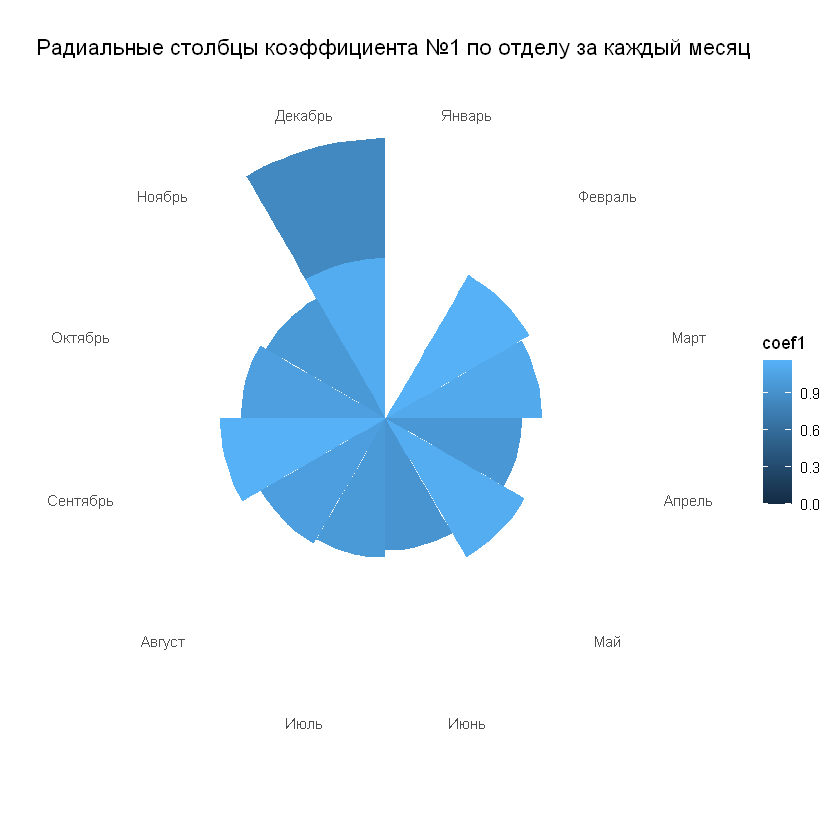

In [96]:
# Данный график визуально показывает, в какие месяцы коэффициент был высоким, а в какие низким или отсутствовал
# Подготовка данных по отделу за каждый месяц и визуализация 
  result$department_month %>%
  mutate(
    month_num = factor(
      match(month, c(
        "Январь","Февраль","Март","Апрель","Май",
        "Июнь","Июль","Август","Сентябрь","Октябрь",
        "Ноябрь","Декабрь")),
      levels = 1:12,
      labels = c(
        "Январь","Февраль","Март","Апрель","Май",
        "Июнь","Июль","Август","Сентябрь","Октябрь",
        "Ноябрь","Декабрь")),
    coef1 = ifelse(is.nan(coef1), 0, coef1),
    coef2 = ifelse(is.nan(coef2), 0, coef2)
  ) %>%
  ggplot(aes(x = month_num, y = coef1, fill = coef1)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar(start = 0) +
  theme_minimal() +
  labs(
    title = "Радиальные столбцы коэффициента №1 по отделу за каждый месяц",
    x = "",
    y = "") +
  theme(
    axis.text.y = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank()
  )
